# Clustering
Perform data clustering (try several methods for this purpose, at least 3) and check if there are any segments of borrowers, use appropriate methods for the optimal number of clusters (40 points)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#importing the PCA scaling library
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import Ridge, Lasso
# Import KNN Regressor machine learning library
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
# Import stats from scipy
from scipy import stats
# Import zscore for scaling
from scipy.stats import zscore
#importing the metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
# importing the Polynomial features
from sklearn.preprocessing import PolynomialFeatures
#importing kmeans clustering library
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.datasets import make_classification
from numpy import where
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
dummies_loan_status = pd.read_csv('dummies_loan_status.csv')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', None)
dummies_loan_status.head()

,Unnamed: 0,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,FICO_group_Exeptional,FICO_group_Fair,FICO_group_Good,FICO_group_Very Good
0,0,5000.0,5000.0,0,10.65,162.87,2,6,10,24000.0,...,0,0,0,0,0,0,0,0,1,0
1,1,2500.0,2500.0,1,15.27,59.83,3,13,0,30000.0,...,0,0,0,0,0,0,0,0,0,1
2,2,2400.0,2400.0,0,15.96,84.33,3,14,10,12252.0,...,0,0,0,1,0,0,0,0,1,0
3,3,10000.0,10000.0,0,13.49,339.31,3,10,10,49200.0,...,0,1,0,0,0,0,0,0,1,0
4,4,3000.0,3000.0,1,12.69,67.79,2,9,1,80000.0,...,0,1,0,0,0,0,0,0,1,0


In [3]:
dummies_loan_status.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
dummies_loan_status.shape

(42535, 64)

In [5]:
# define dataset
X = dummies_loan_status.drop('loan_status', axis = 1)
y = dummies_loan_status.loan_status

In [6]:
X.shape, y.shape

((42535, 63), (42535,))

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver = 'full')
df_pca = pca.fit_transform(X)
loan_pca = pd.DataFrame(df_pca, columns=['c1', 'c2'], index=X.index)
loan_pca.head()

,c1,c2
0,-45598.954521,2541.373081
1,-41496.481034,-11398.997627
2,-58825.222672,-7632.138682
3,-20773.890655,-6191.941273
4,11175.261800,8563.529718


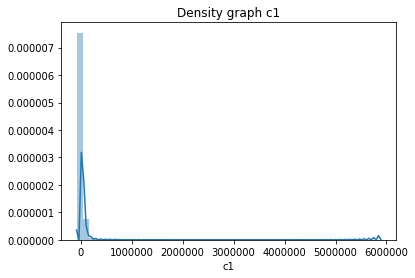

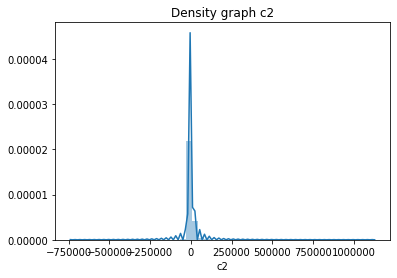

In [8]:
sns.distplot(loan_pca.c1).set(title = 'Density graph c1')
plt.show()
sns.distplot(loan_pca.c2).set(title = 'Density graph c2')
plt.show()

In [9]:
for col in loan_pca:
    if loan_pca[col].min() <= 0:
        loan_pca[col] = loan_pca[col] + np.abs(loan_pca[col].min()) + 1

In [10]:
loan_pca = np.log(loan_pca)

In [11]:
q1 = loan_pca.quantile(0.25)
q3 = loan_pca.quantile(0.75)
iqr = q3 - q1

low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_outliers_L = (loan_pca[iqr.index] < low_boundary).sum()
num_of_outliers_U = (loan_pca[iqr.index] > upp_boundary).sum()
outliers = pd.DataFrame({'lower_boundary':low_boundary, 'upper_boundary':upp_boundary,'num_of_outliers__lower_boundary':num_of_outliers_L, 'num_of_outliers__upper_boundary':num_of_outliers_U})
outliers

,lower_boundary,upper_boundary,num_of_outliers__lower_boundary,num_of_outliers__upper_boundary
c1,9.571382,12.418941,451,440
c2,13.468099,13.543298,168,2407


In [12]:
for row in outliers.iterrows():
    loan_pca = loan_pca[(loan_pca[row[0]] >= row[1]['lower_boundary']) & (loan_pca[row[0]] <= row[1]['upper_boundary'])]

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(loan_pca)
loan_pca_std = scaler.transform(loan_pca)
loan_pca_df = pd.DataFrame(data=loan_pca_std, index=loan_pca.index, columns=loan_pca.columns)

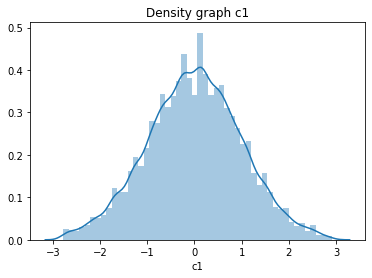

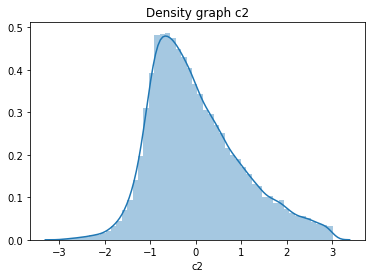

,c1,c2
mean,0.00,-0.00
std,1.00,1.00
max,2.91,3.01
min,-2.78,-2.93


In [14]:
sns.distplot(loan_pca_df.c1).set(title = 'Density graph c1')
plt.show()
sns.distplot(loan_pca_df.c2).set(title = 'Density graph c2')
plt.show()
loan_pca_df.agg(['mean', 'std', 'max', 'min']).round(2)

In [15]:
loan_pca = loan_pca_df.sample(1000, random_state=42)

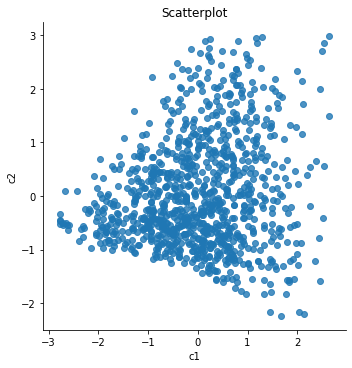

In [16]:
sns.lmplot('c1', 'c2', data = loan_pca, fit_reg=False).set(title = 'Scatterplot')
plt.show()

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
model_AggCl = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3).fit(loan_pca)
loan_pca['AggCl'] = model_AggCl.labels_

In [18]:
silhouette_score(loan_pca[['c1', 'c2']], loan_pca['AggCl']).round(4)

0.35

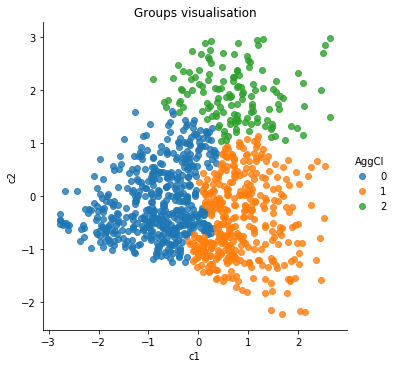

In [19]:
sns.lmplot('c1', 'c2', data = loan_pca, hue = 'AggCl', fit_reg=False).set(title='Groups visualisation')
plt.show()

In [20]:
model_link = linkage(loan_pca.iloc[:,0:2], method = 'ward', metric = 'euclidean')

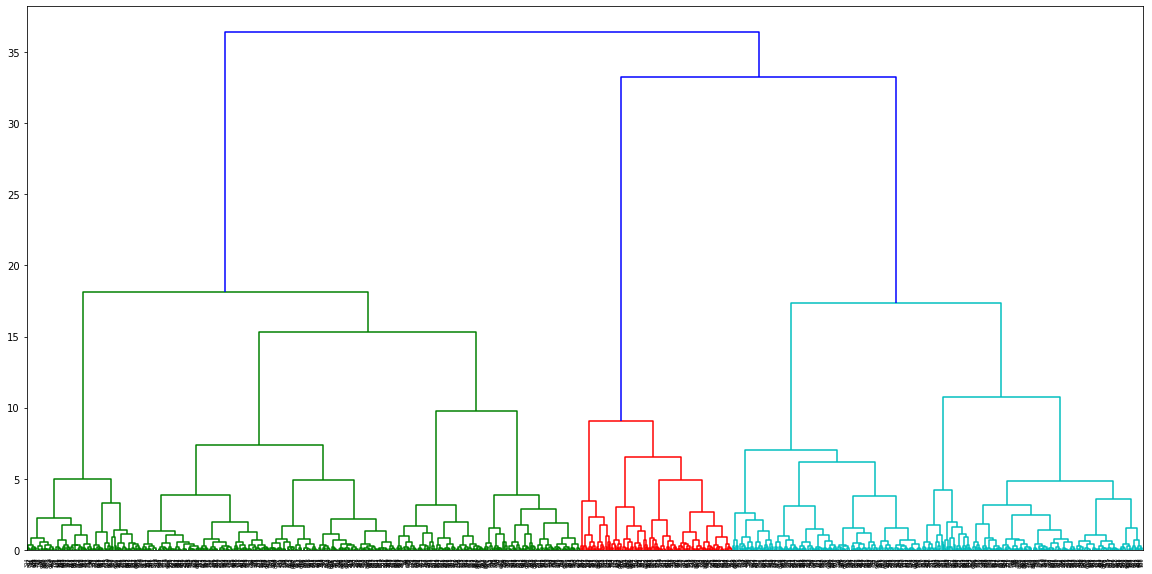

In [21]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(model_link)
plt.show()

In [22]:
clusters = fcluster(model_link, 3, criterion='maxclust')
loan_pca['linkage'] = clusters

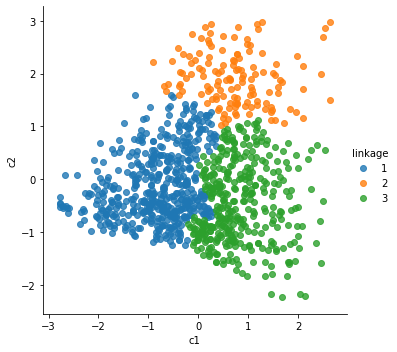

In [23]:
sns.lmplot('c1', 'c2', data = loan_pca, fit_reg=False, hue = 'linkage')
plt.show()

In [24]:
silhouette_score(loan_pca[['c1', 'c2']], loan_pca['linkage']).round(4)

0.35

In [25]:
from sklearn.cluster import DBSCAN
model_DBSCAN = DBSCAN(eps = 0.3, min_samples=30, leaf_size=60).fit(loan_pca.iloc[:,0:2])
loan_pca['DBSCAN'] = model_DBSCAN.labels_

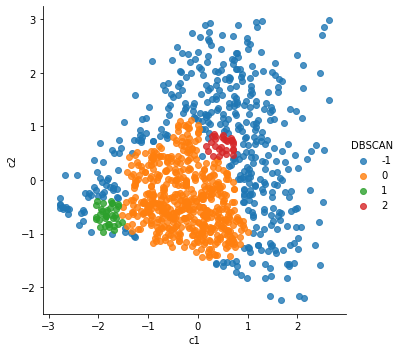

In [26]:
sns.lmplot('c1', 'c2', data = loan_pca, fit_reg=False, hue = 'DBSCAN')
plt.show()

In [27]:
silhouette_score(loan_pca[['c1', 'c2']], loan_pca['DBSCAN']).round(4)

-0.0761

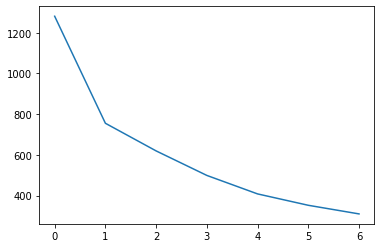

In [28]:
ssd = [] # Sum of squared distances
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(loan_pca.iloc[:,0:2])
    
    ssd.append(kmeans.inertia_) #Sum of squared distances
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [29]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(loan_pca.iloc[:,0:2])
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(loan_pca.iloc[:,0:2], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3816976221770342
For n_clusters=3, the silhouette score is 0.40604367000292735
For n_clusters=4, the silhouette score is 0.3457580616687355
For n_clusters=5, the silhouette score is 0.35407002870749266
For n_clusters=6, the silhouette score is 0.3591712192089558
For n_clusters=7, the silhouette score is 0.35500524137486433
For n_clusters=8, the silhouette score is 0.3519194312243556


In [30]:
model_km = KMeans(n_clusters=4, max_iter=1000, random_state=42)
model_km.fit(loan_pca.iloc[:,0:2])
loan_pca['KMeans'] = model_km.labels_

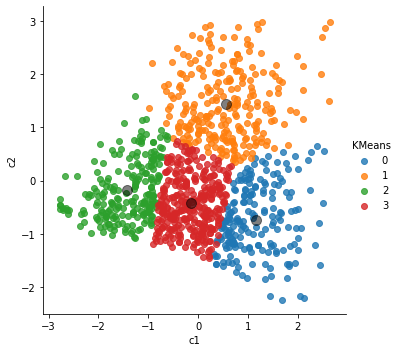

In [31]:
sns.lmplot('c1', 'c2', data = loan_pca, fit_reg=False, hue = 'KMeans')
plt.scatter(model_km.cluster_centers_[:, 0], model_km.cluster_centers_[:, 1], c='black', s=100, alpha=0.5)
plt.show()

In [32]:
silhouette_score(loan_pca[['c1', 'c2']], loan_pca['KMeans']).round(4)

0.3458

In [33]:
loan_pca

,c1,c2,AggCl,linkage,DBSCAN,KMeans
42264,0.667631,-1.167507,1,3,0,0
18460,1.309063,-0.233682,1,3,-1,0
17732,0.110622,-0.352054,0,1,0,3
29983,-1.927235,-0.254244,0,1,-1,2
17965,-1.848985,-0.677952,0,1,1,2
24108,-0.846250,-0.504094,0,1,0,2
5271,0.700275,2.168820,2,2,-1,1
4370,-0.083443,-0.719927,1,3,0,3
35241,-0.980951,-0.578071,0,1,0,2
2400,-2.144747,-0.974607,0,1,-1,2


As we can see above 4 different models created from 3 to 4 clusters. As I worked on the 1000 observation sample, I'm going to choose one (KMeans) and elaborate it with whole dataset in a new notebook